# import packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [91]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_confusion_matrix
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.inspection import permutation_importance

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


# download the dataset

Dataset is downloaded directly using GitHub link. The zip file is then extracted to the currentpath.

In [5]:
!git clone https://github.com/CapitalOneRecruiting/DS

fatal: destination path 'DS' already exists and is not an empty directory.


In [6]:
with zipfile.ZipFile('DS/transactions.zip', 'r') as f:
    f.extractall()

Reading the transactions.txt file in json format and replacing the missing values with np.nan

In [7]:
dataset = pd.read_json('transactions.txt', lines=True)
dataset.replace('', np.nan, inplace=True)

# dataset information and statistics

In [8]:
dataset.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                781801 non-null  object 
 8   merchantCountryCode       785639 non-null  object 
 9   posEntryMode              782309 non-null  object 
 10  posConditionCode          785954 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

From the above info, we can see that there are some missing values in the dataset for few columns.
<br>
For the columns echoBuffer, merchantCity, merchantState, merchantZip, posOnPremises, recurringAuthInd - all the values are missing.
<br>
We can drop these columns from our dataset.

In [10]:
dataset.drop(columns = ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 
                        'posOnPremises', 'recurringAuthInd'], inplace=True)

Below information shows the statistics of the numerical fields in the dataset. <br>
We can see that all the values for columns accountNumber and customerId are the same.

In [11]:
dataset.describe()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,currentBalance
count,7.863630e+05,7.863630e+05,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000
mean,5.372326e+08,5.372326e+08,10759.464459,6250.725369,136.985791,544.467338,544.183857,4757.417799,4508.739089
std,2.554211e+08,2.554211e+08,11636.174890,8880.783989,147.725569,261.524220,261.551254,2996.583810,6457.442068
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,0.000000,100.000000,0.000000,0.000000,0.000000
25%,3.301333e+08,3.301333e+08,5000.000000,1077.420000,33.650000,310.000000,310.000000,2178.000000,689.910000
50%,5.074561e+08,5.074561e+08,7500.000000,3184.860000,87.900000,535.000000,535.000000,4733.000000,2451.760000
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,191.480000,785.000000,785.000000,7338.000000,5291.095000
max,9.993896e+08,9.993896e+08,50000.000000,50000.000000,2011.540000,998.000000,998.000000,9998.000000,47498.810000


Below information shows the statistics of the non-numerical or categorical variables in the dataset. <br> <br>
The count shows number of values for each column. <br>
For some of the columns, the count is low due to missing values.<br>
The unique shoes the number of unique values in each column. <br>
The top shows the value that is the most repeating value in a particular column. <br>The freq is the frequency of the top or most repeating value. <br> <br>
Most of the transactions are from US and through "online_retail".

In [12]:
dataset.describe(exclude=[np.number])

,transactionDateTime,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,transactionType,cardPresent,expirationDateKeyInMatch,isFraud
count,786363,786363,781801,785639,782309,785954,786363,786363,786363,786363,785665,786363,786363,786363
unique,776637,2490,4,4,5,3,19,165,1820,2184,3,2,2,2
top,2016-12-25T14:04:15,Uber,US,US,05,01,online_retail,03/2029,2014-06-21,2016-03-15,PURCHASE,False,False,False
freq,4,25613,774709,778511,315035,628787,202156,5103,33623,3819,745193,433495,785320,773946


# handling missing values

We can see that some of the columns have missing values.

In [13]:
dataset.isna().sum()

accountNumber                  0
customerId                     0
creditLimit                    0
availableMoney                 0
transactionDateTime            0
transactionAmount              0
merchantName                   0
acqCountry                  4562
merchantCountryCode          724
posEntryMode                4054
posConditionCode             409
merchantCategoryCode           0
currentExpDate                 0
accountOpenDate                0
dateOfLastAddressChange        0
cardCVV                        0
enteredCVV                     0
cardLast4Digits                0
transactionType              698
currentBalance                 0
cardPresent                    0
expirationDateKeyInMatch       0
isFraud                        0
dtype: int64

As all the columns/fields that contain missing values are of categorical type, we can fill the missing values using mode or most repeated value from that particular column.

In [14]:
dataset.fillna(dataset.mode().iloc[0], inplace=True)
dataset.isna().sum()

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
currentBalance              0
cardPresent                 0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

# feature creation

Converting the transactionDateTime column to datetime format.

In [15]:
dataset['transactionDateTime'] = pd.to_datetime(dataset['transactionDateTime'])

As we cannot directly work with dattime fields for training the models, created two new columns "DayofWeek" and "Hour" from the "transactionDateTime" column. <br>
These two columns were created based on assumption that fraud transactions happen most during certain days and during certain hours of the day.
<br> <br>
NOTE :  Created "Quarter" and "Month" columns from "transactionDateTime". Have removed them as they were not that useful in the models. <br>
Also created bins from "Hour" column. Have created four bins for 24 hours. Removed the feature as it was not useful when it comes to model.

In [16]:
dataset['transactionDateTime_dayofweek'] = dataset['transactionDateTime'].dt.dayofweek
dataset['transactionDateTime_hour'] = dataset['transactionDateTime'].dt.hour

This feature is based on the assumption that a fraud do not know the balance amount in a particular account. <br> So, an amount greater than available balance can be used from the card in that case.

In [17]:
dataset['TA>AM'] = dataset['transactionAmount'] > dataset['availableMoney']

Creating new feature/column "CVVMatched" which will be True if cvv from "cardCVV" and "enteredCVV" are the same. <br>
As both the columns has only CVV values, they are not useful for machine learning models. <br> 
The new feature "CVVMatched" will be able to retain some amount of information from the other two features "cardCVV" and "enteredCVV"

In [18]:
dataset['CVVMatched'] = dataset['cardCVV']==dataset['enteredCVV']

Final dataset after feature creation

In [19]:
dataset.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dayofweek,transactionDateTime_hour,TA>AM,CVVMatched
0,737265056,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,...,1803,PURCHASE,0.0,False,False,False,5,14,False,True
1,737265056,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,...,767,PURCHASE,0.0,True,False,False,1,5,False,True
2,737265056,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,...,767,PURCHASE,0.0,False,False,False,1,9,False,True
3,737265056,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,...,767,PURCHASE,0.0,False,False,False,5,2,False,True
4,830329091,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,...,3143,PURCHASE,0.0,True,False,False,3,21,False,True


# data analysis and visualization

Dataset is highly imbalanced

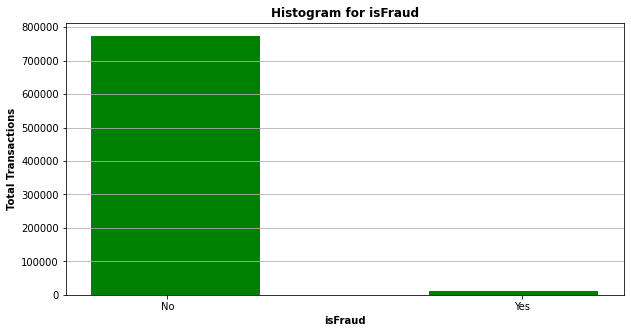

In [476]:
plt.figure(figsize=(10,5))
plt.grid(axis='y')
plt.hist(dataset['isFraud'].values*1, bins=3, color='green')
plt.title('Histogram for isFraud', fontweight='bold')
plt.xlabel('isFraud', fontweight='bold')
plt.ylabel('Total Transactions', fontweight='bold')
plt.xticks([0.15,0.85],['No','Yes'])
plt.show()

Creating a copy of only fraud transactions for analysis

In [438]:
fraud_data = dataset[dataset['isFraud']==True]

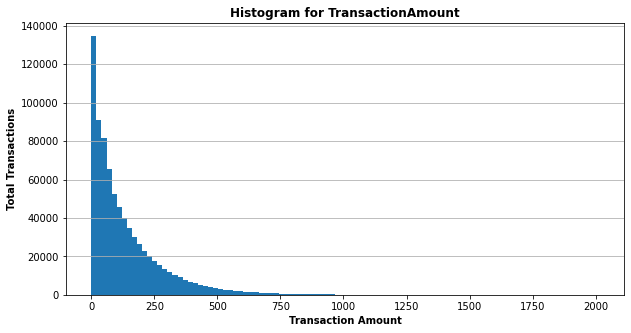

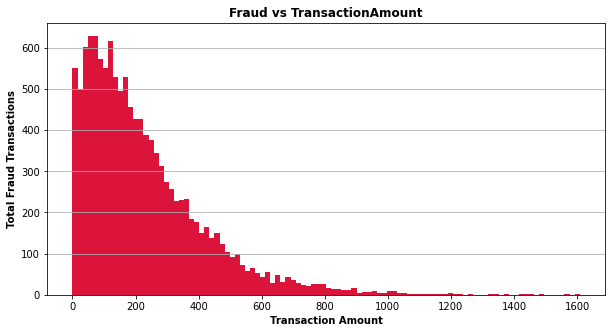

In [455]:
plt.figure(figsize=(10,5))
plt.grid(axis='y')
plt.hist(dataset['transactionAmount'].values, bins=100)
plt.title('Histogram for TransactionAmount', fontweight='bold')
plt.xlabel('Transaction Amount', fontweight='bold')
plt.ylabel('Total Transactions', fontweight='bold')
plt.show()

plt.figure(figsize=(10,5))
plt.grid(axis='y')
plt.hist(fraud_data['transactionAmount'].values, bins=100, color='crimson')
plt.title('Fraud vs TransactionAmount', fontweight='bold')
plt.xlabel('Transaction Amount', fontweight='bold')
plt.ylabel('Total Fraud Transactions', fontweight='bold')
plt.show()

From the above histogram we can see that most of the transaction amounts are less than 500. <br>
From below histogram, we can see that most of the fraud transaction amounts are low. <br>
If we consider a frequency of 100, the transactions amounts are < 500.


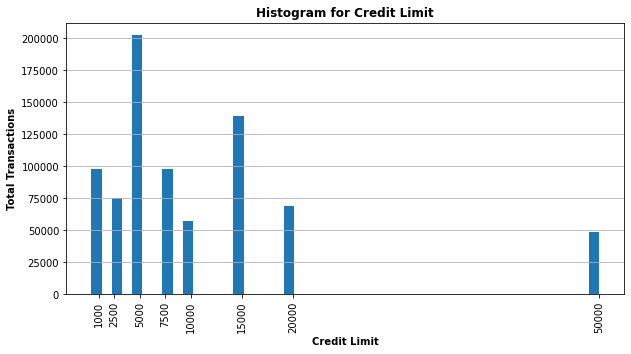

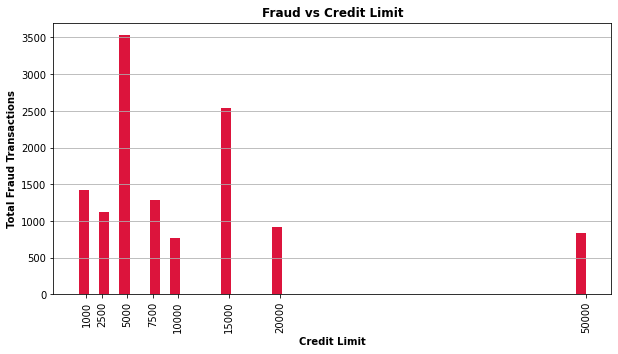

In [456]:
plt.figure(figsize=(10,5))
plt.grid(axis='y')
plt.hist(dataset['creditLimit'].values, bins=50)
plt.title('Histogram for Credit Limit', fontweight='bold')
plt.xlabel('Credit Limit', fontweight='bold')
plt.ylabel('Total Transactions', fontweight='bold')
plt.xticks([1000,2500,5000,7500,10000,15000,20000,50000], rotation=90)
plt.show()

plt.figure(figsize=(10,5))
plt.grid(axis='y')
plt.hist(fraud_data['creditLimit'].values, bins=50, color='crimson')
plt.title('Fraud vs Credit Limit', fontweight='bold')
plt.xlabel('Credit Limit', fontweight='bold')
plt.ylabel('Total Fraud Transactions', fontweight='bold')
plt.xticks([1000,2500,5000,7500,10000,15000,20000,50000], rotation=90)
plt.show()

From above graphs, we can see that credit limit of 5000 is more compared to other credit limits. <br>
Also the number of fraud transactions is relatively high for accounts with credit limit of 5000.

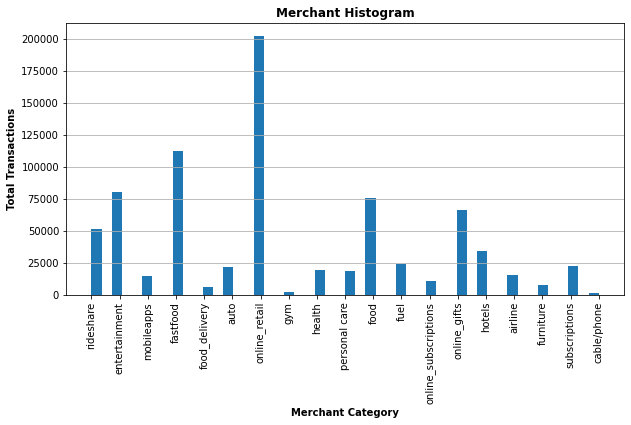

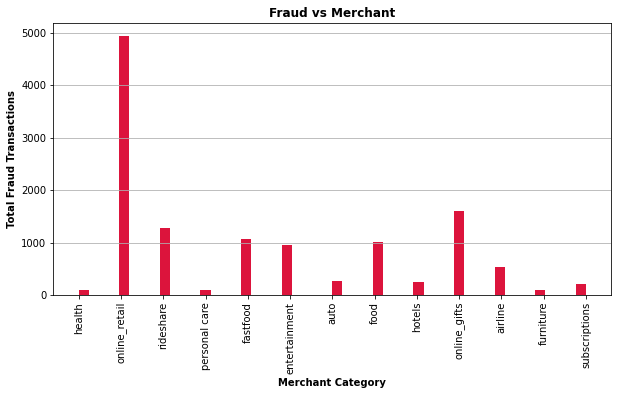

In [457]:
plt.figure(figsize=(10,5))
plt.grid(axis='y')
plt.hist(dataset['merchantCategoryCode'].values, bins=50)
plt.title('Merchant Histogram', fontweight='bold')
plt.xlabel('Merchant Category', fontweight='bold')
plt.ylabel('Total Transactions', fontweight='bold')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10,5))
plt.grid(axis='y')
plt.hist(fraud_data['merchantCategoryCode'].values, bins=50, color='crimson')
plt.title('Fraud vs Merchant', fontweight='bold')
plt.xlabel('Merchant Category', fontweight='bold')
plt.ylabel('Total Fraud Transactions', fontweight='bold')
plt.xticks(rotation=90)
plt.show()

From Merchant histograms, we can see that online retail has most number of transactions compared to others. <br>
Also the online retail has the most number of fraud transactions. <br>

The Merchants like "rideshare", "mobileapps", "food_delivery", "online_retail", "gym", "fuel", "online_subscriptions", "hotels", "cable/phone" does not have any fraud transactions.


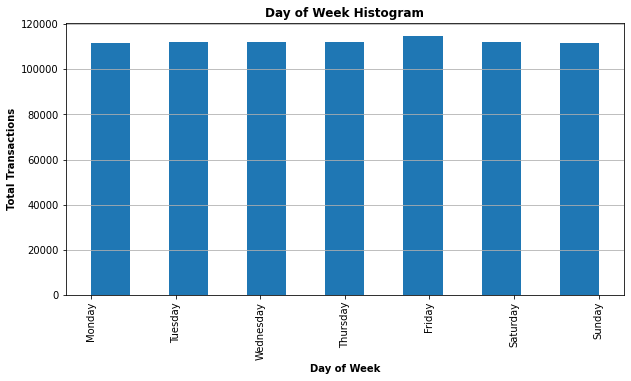

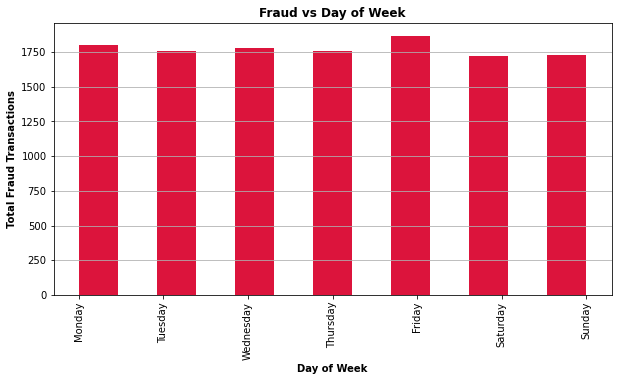

In [459]:
plt.figure(figsize=(10,5))
plt.grid(axis='y')
plt.hist(dataset['transactionDateTime_dayofweek'].values, bins=13)
plt.title('Day of Week Histogram', fontweight='bold')
plt.xlabel('Day of Week', fontweight='bold')
plt.ylabel('Total Transactions', fontweight='bold')
plt.xticks([0,1,2,3,4,5,6],['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], rotation=90)
plt.show()

plt.figure(figsize=(10,5))
plt.grid(axis='y')
plt.hist(fraud_data['transactionDateTime_dayofweek'].values, bins=13, color='crimson')
plt.title('Fraud vs Day of Week', fontweight='bold')
plt.xlabel('Day of Week', fontweight='bold')
plt.ylabel('Total Fraud Transactions', fontweight='bold')
plt.xticks([0,1,2,3,4,5,6],['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], rotation=90)
plt.show()

From above graph, the total transactions and total fraud transactions are almost same on everyday.

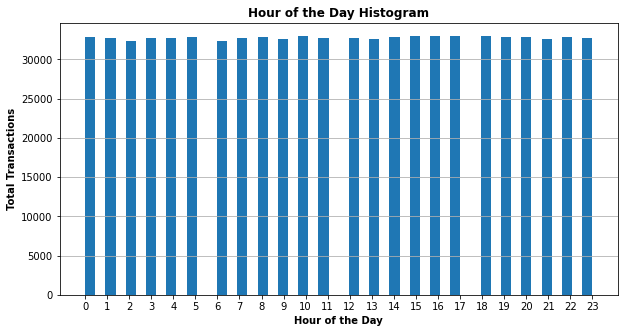

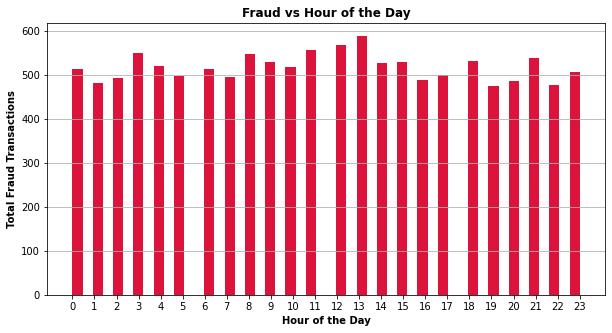

In [460]:
plt.figure(figsize=(10,5))
plt.grid(axis='y')
plt.hist(dataset['transactionDateTime_hour'].values, bins=50)
plt.title('Hour of the Day Histogram', fontweight='bold')
plt.xlabel('Hour of the Day', fontweight='bold')
plt.ylabel('Total Transactions', fontweight='bold')
plt.xticks(list(range(0,24)))
plt.show()

plt.figure(figsize=(10,5))
plt.grid(axis='y')
plt.hist(fraud_data['transactionDateTime_hour'].values, bins=50, color='crimson')
plt.title('Fraud vs Hour of the Day', fontweight='bold')
plt.xlabel('Hour of the Day', fontweight='bold')
plt.ylabel('Total Fraud Transactions', fontweight='bold')
plt.xticks(list(range(0,24)))
plt.show()

From above graph, the total transactions and total fraud transactions are almost same on every hour of the day.

# duplicate transactions (refund and multiswipe)

Upon thorough analysis on the dataset, refund can be identified from the feature "transactionType" which has "REVERSAL" category for refund transactions. <br><br>
Multiswipe transactions can be identified using the feature "transactionDateTime". For a duplicate transaction of this type to happen, transactions must be on the same day from the same "accountNumber". Also the "transactionAmount" and "Merchant" should be the same. <br><br>
NOTE: verified that all reversal transactions have a purchase transaction before in the dataset.

Creating data for refund and multiswipe transactions. <br> <br>
dup_mul_df dataframe will contain both original and duplicate transactions for multiswipe.

In [461]:
dup_data = dataset[['accountNumber','transactionDateTime','transactionAmount','merchantName','transactionType']]
s = list(set(dup_data['accountNumber'].values))

In [ ]:
dup_mul = []

for i in range(len(s)):
    temp = dup_data[dup_data['accountNumber'] == s[i]]
    temp.reset_index(inplace=True, drop=True)
    
    temp_nr = temp[temp['transactionType'] != 'REVERSAL']
    temp_nr.reset_index(inplace=True, drop=True)
    
    for j in range(0, len(temp_nr)-1):
        flag = 0
        
        for k in range(j+1, len(temp_nr)):
        
            time_diff = (temp_nr['transactionDateTime'][k] - temp_nr['transactionDateTime'][j])
            
            if time_diff.days < 1:
            
                if temp_nr['transactionAmount'][j] == temp_nr['transactionAmount'][k] and \
                temp_nr['merchantName'][j] == temp_nr['merchantName'][k]:

                    dup_mul.append(temp_nr.iloc[j,:])
                    dup_mul.append(temp_nr.iloc[k,:])
                    
            else:
                flag += 1
            
            if flag == 5:
                break

dup_mul = np.array(dup_mul)
dup_mul_df = pd.DataFrame(dup_mul, columns=dup_data.columns)
dup_mul_df.drop_duplicates(inplace=True)

In [464]:
dup_mul_df.head(10)

,accountNumber,transactionDateTime,transactionAmount,merchantName,transactionType
0,863174657,2016-06-04 18:07:59,140.5,walmart.com,PURCHASE
1,863174657,2016-06-04 18:10:28,140.5,walmart.com,PURCHASE
2,687177729,2016-04-15 08:13:03,21.29,Lyft,PURCHASE
3,687177729,2016-04-15 08:13:09,21.29,Lyft,PURCHASE
4,169738244,2016-07-09 03:28:04,190.01,Lyft,PURCHASE
5,169738244,2016-07-09 03:30:25,190.01,Lyft,PURCHASE
6,737181728,2016-05-30 12:25:24,29.14,Best Bistro #262998,PURCHASE
7,737181728,2016-05-30 12:27:41,29.14,Best Bistro #262998,PURCHASE
8,737181728,2016-05-30 20:07:24,22.88,1st Pub,PURCHASE
9,737181728,2016-05-30 20:08:55,22.88,1st Pub,PURCHASE


Plotting total amount for Refund and MultiSwipe transactions

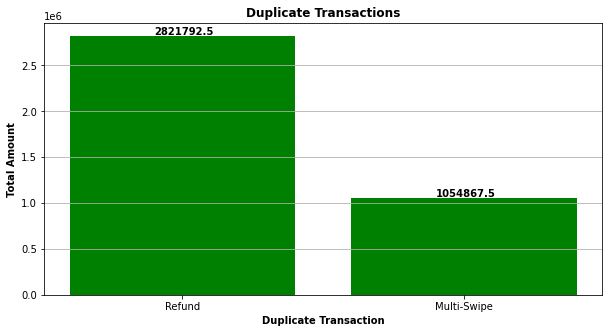

In [489]:
x = [0,1]
y=[]
refund = dataset[dataset['transactionType'] == 'REVERSAL']
y.append(refund['transactionAmount'].sum())
y.append(round(dup_mul_df['transactionAmount'].sum(),2)/2)

plt.figure(figsize=(10,5))
plt.grid(axis='y')
plt.bar(x, y, color='green')
plt.title('Duplicate Transactions', fontweight='bold')
plt.xlabel('Duplicate Transaction', fontweight='bold')
plt.ylabel('Total Amount', fontweight='bold')
plt.xticks([0,1],['Refund','Multi-Swipe'])
for i in range(len(x)):
    plt.text(x[i]-0.1, y[i]+10000, str(y[i]), fontweight='bold')
plt.show()

# data preprocessing

Drop unwanted columns.

In [20]:
dataset.drop(columns=['accountNumber','customerId','transactionDateTime','merchantName',
                      'currentExpDate','accountOpenDate','dateOfLastAddressChange',
                      'cardCVV','enteredCVV','cardLast4Digits'], inplace=True)

Replace True False with 1 and 0.

In [21]:
dataset.replace(to_replace={False: 0, True: 1},inplace=True)

Data preprocessing will be done separately for tree based(DecisionTree, RandomForest etc) and non-tree based models(LogisticRegression, SVM etc). <br><br>
This is because, tree models do not require one-hot encodings for categorical variables and also do not need Normalizing the dataset.

## data processing for tree based models

Creating dataset copy and encoding the categorical variables.

In [22]:
dataset_tree = deepcopy(dataset)

le_acqCountry = LabelEncoder()
le_merchantCountryCode = LabelEncoder()
le_merchantCategoryCode = LabelEncoder()
le_transactionType = LabelEncoder()

dataset_tree['acqCountry'] = le_acqCountry.fit_transform(dataset_tree['acqCountry'])
dataset_tree['merchantCountryCode'] = le_merchantCountryCode.fit_transform(dataset_tree['merchantCountryCode'])
dataset_tree['merchantCategoryCode'] = le_merchantCategoryCode.fit_transform(dataset_tree['merchantCategoryCode'])
dataset_tree['transactionType'] = le_transactionType.fit_transform(dataset_tree['transactionType'])
dataset_tree.head()

,creditLimit,availableMoney,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dayofweek,transactionDateTime_hour,TA>AM,CVVMatched
0,5000,5000.0,98.55,3,3,02,01,17,1,0.0,0,0,0,5,14,0,1
1,5000,5000.0,74.51,3,3,09,01,3,1,0.0,1,0,0,1,5,0,1
2,5000,5000.0,7.47,3,3,09,01,12,1,0.0,0,0,0,1,9,0,1
3,5000,5000.0,7.47,3,3,09,01,12,1,0.0,0,0,0,5,2,0,1
4,5000,5000.0,71.18,3,3,02,01,4,1,0.0,1,0,0,3,21,0,1


## data preprocessing for non-tree models
Creating dummy fields for categorical variables

In [24]:
dataset = pd.get_dummies(dataset, columns=['acqCountry','merchantCountryCode','posEntryMode','posConditionCode',
                                 'merchantCategoryCode','transactionType','transactionDateTime_dayofweek',
                                 'transactionDateTime_hour'], drop_first=True)
dataset.head()

,creditLimit,availableMoney,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,TA>AM,CVVMatched,acqCountry_MEX,...,transactionDateTime_hour_14,transactionDateTime_hour_15,transactionDateTime_hour_16,transactionDateTime_hour_17,transactionDateTime_hour_18,transactionDateTime_hour_19,transactionDateTime_hour_20,transactionDateTime_hour_21,transactionDateTime_hour_22,transactionDateTime_hour_23
0,5000,5000.0,98.55,0.0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,5000,5000.0,74.51,0.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,5000,5000.0,7.47,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,5000,5000.0,7.47,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5000,5000.0,71.18,0.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


## split dataset into train and test sets

In [25]:
y = dataset['isFraud'].values
dataset.drop(columns=['isFraud'],inplace=True)
dataset_tree.drop(columns=['isFraud'],inplace=True)
X = dataset.iloc[:,:].values
X_tree = dataset_tree.iloc[:,:].values

Train Test Split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(X_tree, y, test_size=0.2, random_state=0)

Normalizing the dataset for non-tree models

In [33]:
mm = MinMaxScaler()
mm.fit(X_train)
X_train = mm.transform(X_train)
X_test = mm.transform(X_test)

## under sampling the training set<br>
NOTE: Also performed over-sampling the training set and modelling. Under-sampling is giving better performance than over-sampling.

Before under sampling - class imbalance

In [31]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[[     0 619105]
 [     1   9985]]


In [34]:
unique, counts = np.unique(y_tree_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[[     0 619105]
 [     1   9985]]


Under sampling

In [35]:
under_sampler = RandomUnderSampler(random_state=0)
X_train_sampled, y_train_sampled = under_sampler.fit_resample(X_train, y_train)
X_tree_train_sampled, y_tree_train_sampled = under_sampler.fit_resample(X_tree_train, y_tree_train)

After under sampling - classes are balanced

In [36]:
unique, counts = np.unique(y_train_sampled, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 9985]
 [   1 9985]]


In [38]:
unique, counts = np.unique(y_tree_train_sampled, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 9985]
 [   1 9985]]


# Models

## Decision Tree

Finding best parameters through GridSearch and CrossValidation score

In [40]:
dt_model = DecisionTreeClassifier(random_state=0)

dt_parameters = {'criterion' : ['gini', 'entropy'],
                 'max_depth' : [5,6,7,8,9,10]}
gcv_dtree = GridSearchCV(dt_model, dt_parameters, cv=5, n_jobs=-1, scoring='accuracy')
gcv_dtree.fit(X_tree_train_sampled, y_tree_train_sampled)
print('Best model parameters : ',gcv_dtree.best_params_)
print('Best model score : ',gcv_dtree.best_score_)

Best model parameters :  {'criterion': 'entropy', 'max_depth': 8}
Best model score :  0.6773660490736104


Fitting the model and evaluating on test set

Training Accuracy :  0.7093640460691036
Testing Accuracy :  0.6866849363845033

Report :
              precision    recall  f1-score   support

   Not Fraud       0.99      0.69      0.81    154841
       Fraud       0.03      0.68      0.06      2432

    accuracy                           0.69    157273
   macro avg       0.51      0.69      0.44    157273
weighted avg       0.98      0.69      0.80    157273


Confusion Matrix :


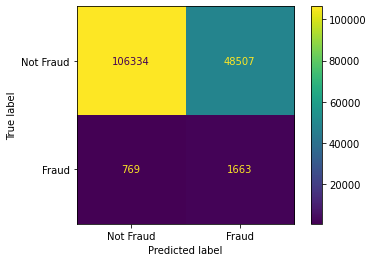

In [60]:
dt_model = DecisionTreeClassifier(criterion='entropy',max_depth=8,random_state=0)
dt_model.fit(X_tree_train_sampled, y_tree_train_sampled)

y_pred = dt_model.predict(X_tree_test)

print('Training Accuracy : ', dt_model.score(X_tree_train_sampled, y_tree_train_sampled))
print('Testing Accuracy : ', accuracy_score(y_tree_test, y_pred))

print('\nReport :')
print(classification_report(y_tree_test, y_pred, target_names=['Not Fraud','Fraud']))

print('\nConfusion Matrix :')
plot_confusion_matrix(dt_model,X_tree_test, y_tree_test, labels = [0,1],
                      display_labels = ['Not Fraud','Fraud'])
plt.show()

## Random Forest

Finding best parameters through GridSearch and CrossValidation score

In [54]:
rf_model = RandomForestClassifier(random_state=0)

rf_parameters = {'n_estimators' : [100,200,300],
                 'criterion' : ['gini', 'entropy'],
                 'max_depth' : [7,8,9,10,11,12]}
gcv_rf = GridSearchCV(rf_model, rf_parameters, cv=5, n_jobs=-1, scoring='accuracy')
gcv_rf.fit(X_tree_train_sampled, y_tree_train_sampled)
print('Best model parameters : ',gcv_rf.best_params_)
print('Best model score : ',gcv_rf.best_score_)

Best model parameters :  {'criterion': 'gini', 'max_depth': 12, 'n_estimators': 300}
Best model score :  0.6896845267901852


Fitting the model and evaluating on test set

Training Accuracy :  0.8014021031547321
Testing Accuracy :  0.698810348883788

Report :
              precision    recall  f1-score   support

   Not Fraud       0.99      0.70      0.82    154841
       Fraud       0.04      0.70      0.07      2432

    accuracy                           0.70    157273
   macro avg       0.51      0.70      0.44    157273
weighted avg       0.98      0.70      0.81    157273


Confusion Matrix :


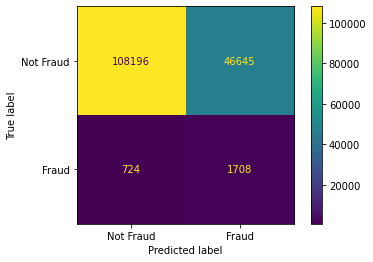

In [61]:
rf_model = RandomForestClassifier(n_estimators=300,criterion='gini',max_depth=12,random_state=0)
rf_model.fit(X_tree_train_sampled, y_tree_train_sampled)

y_pred = rf_model.predict(X_tree_test)

print('Training Accuracy : ', rf_model.score(X_tree_train_sampled, y_tree_train_sampled))
print('Testing Accuracy : ', accuracy_score(y_tree_test, y_pred))

print('\nReport :')
print(classification_report(y_tree_test, y_pred, target_names=['Not Fraud','Fraud']))

print('\nConfusion Matrix :')
plot_confusion_matrix(rf_model,X_tree_test, y_tree_test, labels = [0,1],
                      display_labels = ['Not Fraud','Fraud'])
plt.show()

## XGBoost

Finding best parameters through GridSearch and CrossValidation score

In [59]:
xgb_model = XGBClassifier(random_state=0, n_jobs=-1, objective='binary:logistic',
                          booster='gbtree', eval_metric='logloss')


xgb_parameters = {'n_estimators' : [10,100,300],
                 'max_depth' : [3,4,5,6,7]}
gcv_xgb = GridSearchCV(xgb_model, xgb_parameters, cv=5, n_jobs=-1, scoring='accuracy')
gcv_xgb.fit(X_tree_train_sampled, y_tree_train_sampled)
print('Best model parameters : ',gcv_xgb.best_params_)
print('Best model score : ',gcv_xgb.best_score_)

Best model parameters :  {'max_depth': 3, 'n_estimators': 100}
Best model score :  0.6934401602403606


Fitting the model and evaluating on test set

Training Accuracy :  0.7203805708562844
Testing Accuracy :  0.6929352145632117

Report :
              precision    recall  f1-score   support

   Not Fraud       0.99      0.69      0.82    154841
       Fraud       0.03      0.71      0.07      2432

    accuracy                           0.69    157273
   macro avg       0.51      0.70      0.44    157273
weighted avg       0.98      0.69      0.80    157273


Confusion Matrix :


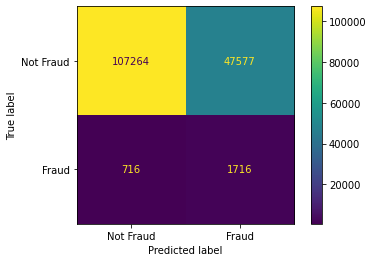

In [63]:
xgb_model = XGBClassifier(random_state=0, n_jobs=-1, objective='binary:logistic', booster='gbtree',
                          max_depth= 3, n_estimators= 100, eval_metric='logloss', use_label_encoder=False)
xgb_model.fit(X_tree_train_sampled, y_tree_train_sampled)

y_pred = xgb_model.predict(X_tree_test)

print('Training Accuracy : ', xgb_model.score(X_tree_train_sampled, y_tree_train_sampled))
print('Testing Accuracy : ', accuracy_score(y_tree_test, y_pred))

print('\nReport :')
print(classification_report(y_tree_test, y_pred, target_names=['Not Fraud','Fraud']))

print('\nConfusion Matrix :')
plot_confusion_matrix(xgb_model,X_tree_test, y_tree_test, labels = [0,1],
                      display_labels = ['Not Fraud','Fraud'])
plt.show()

## Logistic Regression

Finding best parameters through GridSearch and CrossValidation score

In [64]:
lr_model = LogisticRegression(random_state=0, n_jobs=-1, max_iter=10000)

lr_parameters = {'penalty' : ['l1','l2'],
                 'C' : [0.1,1,10,100]}
gcv_lr = GridSearchCV(lr_model, lr_parameters, cv=5, n_jobs=-1, scoring='accuracy')
gcv_lr.fit(X_train_sampled, y_train_sampled)
print('Best model parameters : ',gcv_lr.best_params_)
print('Best model score : ',gcv_lr.best_score_)

Best model parameters :  {'C': 10, 'penalty': 'l2'}
Best model score :  0.6771657486229344


Fitting the model and evaluating on test set

Training Accuracy :  0.6799198798197296
Testing Accuracy :  0.6414769222943544

Report :
              precision    recall  f1-score   support

   Not Fraud       0.99      0.64      0.78    154841
       Fraud       0.03      0.71      0.06      2432

    accuracy                           0.64    157273
   macro avg       0.51      0.68      0.42    157273
weighted avg       0.98      0.64      0.77    157273


Confusion Matrix :


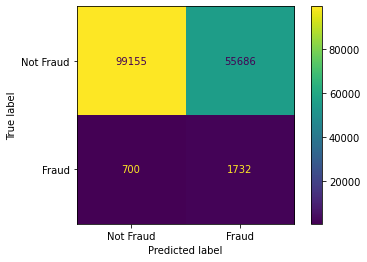

In [66]:
lr_model = LogisticRegression(random_state=0, n_jobs=-1, max_iter=10000, penalty='l2', C=10)
lr_model.fit(X_train_sampled, y_train_sampled)

y_pred = lr_model.predict(X_test)

print('Training Accuracy : ', lr_model.score(X_train_sampled, y_train_sampled))
print('Testing Accuracy : ', accuracy_score(y_test, y_pred))

print('\nReport :')
print(classification_report(y_test, y_pred, target_names=['Not Fraud','Fraud']))

print('\nConfusion Matrix :')
plot_confusion_matrix(lr_model,X_test, y_test, labels = [0,1],
                      display_labels = ['Not Fraud','Fraud'])
plt.show()

## SVM

Finding best parameters through GridSearch and CrossValidation score

In [67]:
lsvm_model = LinearSVC(random_state=0, max_iter=10000)

lsvm_parameters = {'penalty' : ['l1','l2'],
                 'C' : [0.1,1,10,100]}
gcv_lsvm = GridSearchCV(lsvm_model, lsvm_parameters, cv=5, n_jobs=-1, scoring='accuracy')
gcv_lsvm.fit(X_train_sampled, y_train_sampled)
print('Best model parameters : ',gcv_lsvm.best_params_)
print('Best model score : ',gcv_lsvm.best_score_)

Best model parameters :  {'C': 1, 'penalty': 'l2'}
Best model score :  0.6762143214822234


Fitting the model and evaluating on test set

Training Accuracy :  0.6798698047070606
Testing Accuracy :  0.6412289458457586

Report :
              precision    recall  f1-score   support

   Not Fraud       0.99      0.64      0.78    154841
       Fraud       0.03      0.71      0.06      2432

    accuracy                           0.64    157273
   macro avg       0.51      0.68      0.42    157273
weighted avg       0.98      0.64      0.77    157273


Confusion Matrix :


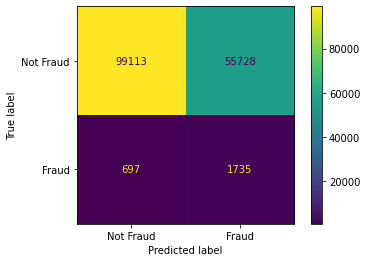

In [68]:
lsvm_model = LinearSVC(random_state=0, max_iter=10000, penalty='l2', C=1)
lsvm_model.fit(X_train_sampled, y_train_sampled)

y_pred = lsvm_model.predict(X_test)

print('Training Accuracy : ', lsvm_model.score(X_train_sampled, y_train_sampled))
print('Testing Accuracy : ', accuracy_score(y_test, y_pred))

print('\nReport :')
print(classification_report(y_test, y_pred, target_names=['Not Fraud','Fraud']))

print('\nConfusion Matrix :')
plot_confusion_matrix(lsvm_model,X_test, y_test, labels = [0,1],
                      display_labels = ['Not Fraud','Fraud'])
plt.show()

## Artificial Neural Network

In [73]:
def evaluate(model, dataset, criterion):
    model.eval()
    acc = 0
    loss = []
    for x, y in dataset:
        x = x.float().to(device)
        y = y.float().to(device)
        y = y.unsqueeze(1)
        out = model(x)
        l = criterion(out, y)
        loss.append(l.item())
        out = torch.round(torch.sigmoid(out))
        acc += torch.sum(out==y).item()

    return 100*acc/len(dataset.dataset), np.mean(np.array(loss))

In [74]:
X_train_sampled = torch.tensor(X_train_sampled)
X_test = torch.tensor(X_test)
y_train_sampled = torch.tensor(y_train_sampled)
y_test = torch.tensor(y_test)

train_set = []
for i in range(len(y_train_sampled)):
    train_set.append((X_train_sampled[i], y_train_sampled[i]))
    
test_set = []
for i in range(len(y_test)):
    test_set.append((X_test[i], y_test[i]))


train_dataloader = DataLoader(train_set, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_set, batch_size = 64, shuffle = True)

In [86]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.network = nn.Sequential(nn.Linear(69, 256),
                                     nn.ReLU(),
                                     nn.Linear(256, 512),
                                     nn.ReLU(),
                                     nn.Linear(512, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, 1),)
    
    def forward(self, x):
        x = self.network(x)
        return x

ann_model = ANN().to(device)
print(ann_model)

ANN(
  (network): Sequential(
    (0): Linear(in_features=69, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [87]:
optimizer = torch.optim.SGD(ann_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

In [88]:
ann_model = ann_model.float()

top_acc = 0

for epoch in range(10):
    ann_model.train()
    for data,targets in train_dataloader:
        data = data.float().to(device)
        targets = targets.float().to(device)
        targets = targets.unsqueeze(1)
        optimizer.zero_grad()
        out = ann_model(data)
        loss = criterion(out, targets)
        loss.backward()
        optimizer.step()
    
    #Train validation
    trn_acc, trn_lss = evaluate(ann_model, train_dataloader, criterion)
    
    #Test validation
    tst_acc, tst_lss = evaluate(ann_model, test_dataloader, criterion)

    print(f'Epoch:{epoch+1:2.0f}\t Train_Loss:{trn_lss:.4f}\t Train_Acc:{trn_acc:.4f}\t Test_Loss:{tst_lss:.4f}\t Test_Acc:{tst_acc:.4f}')
    
    if epoch > 5 and tst_acc > top_acc:
        top_acc = tst_acc
        torch.save(ann_model,'best_model.pt')

Epoch: 1	 Train_Loss:0.6918	 Train_Acc:53.8758	 Test_Loss:0.7001	 Test_Acc:16.3353
Epoch: 2	 Train_Loss:0.6904	 Train_Acc:60.9464	 Test_Loss:0.6907	 Test_Acc:59.3827
Epoch: 3	 Train_Loss:0.6886	 Train_Acc:61.7877	 Test_Loss:0.6893	 Test_Acc:59.5894
Epoch: 4	 Train_Loss:0.6861	 Train_Acc:61.9830	 Test_Loss:0.6898	 Test_Acc:56.5749
Epoch: 5	 Train_Loss:0.6824	 Train_Acc:62.1632	 Test_Loss:0.6879	 Test_Acc:57.2075
Epoch: 6	 Train_Loss:0.6775	 Train_Acc:62.0931	 Test_Loss:0.6868	 Test_Acc:56.5246
Epoch: 7	 Train_Loss:0.6702	 Train_Acc:63.1297	 Test_Loss:0.6648	 Test_Acc:66.5505
Epoch: 8	 Train_Loss:0.6618	 Train_Acc:62.1983	 Test_Loss:0.6865	 Test_Acc:55.7305
Epoch: 9	 Train_Loss:0.6541	 Train_Acc:63.6405	 Test_Loss:0.6499	 Test_Acc:67.2436
Epoch:10	 Train_Loss:0.6488	 Train_Acc:63.7907	 Test_Loss:0.6291	 Test_Acc:69.8938


In [89]:
best_model = torch.load('best_model.pt')

y_pred_ann = best_model(X_test.float())
y_pred_ann = torch.round(torch.sigmoid(y_pred_ann))
y_pred_ann = torch.detach(y_pred_ann).numpy()

print('Accuracy score : ', accuracy_score(y_test, y_pred_ann))
print('Confusion Matrix : ')
print(confusion_matrix(y_test, y_pred_ann))

Accuracy score :  0.6989375162933243
Confusion Matrix : 
[[108499  46342]
 [  1007   1425]]


# feature importance

Decision Tree

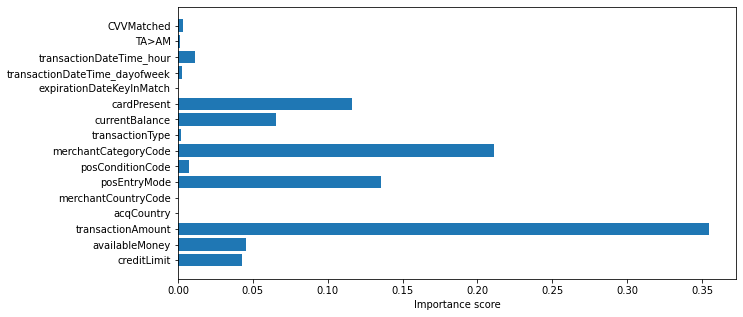

In [95]:
plt.figure(figsize=(10,5))
plt.barh(dataset_tree.columns, dt_model.feature_importances_)
plt.xlabel('Importance score')
plt.show()

Random Forest

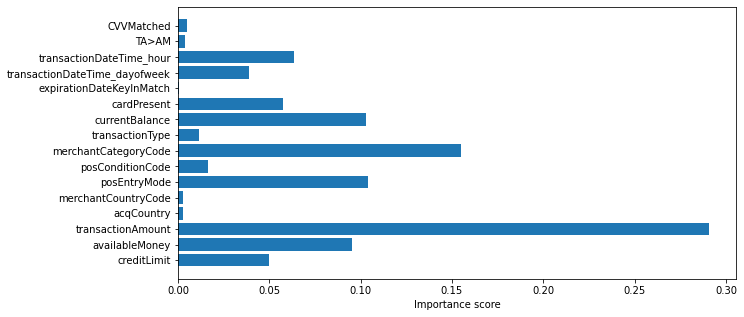

In [96]:
plt.figure(figsize=(10,5))
plt.barh(dataset_tree.columns, rf_model.feature_importances_)
plt.xlabel('Importance score')
plt.show()

XGBoost

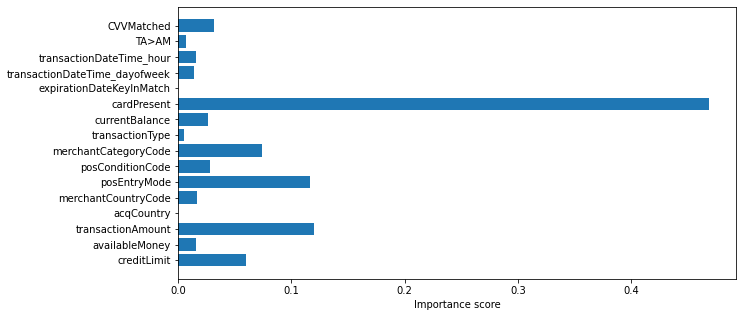

In [97]:
plt.figure(figsize=(10,5))
plt.barh(dataset_tree.columns, xgb_model.feature_importances_)
plt.xlabel('Importance score')
plt.show()

Permutation feature importance

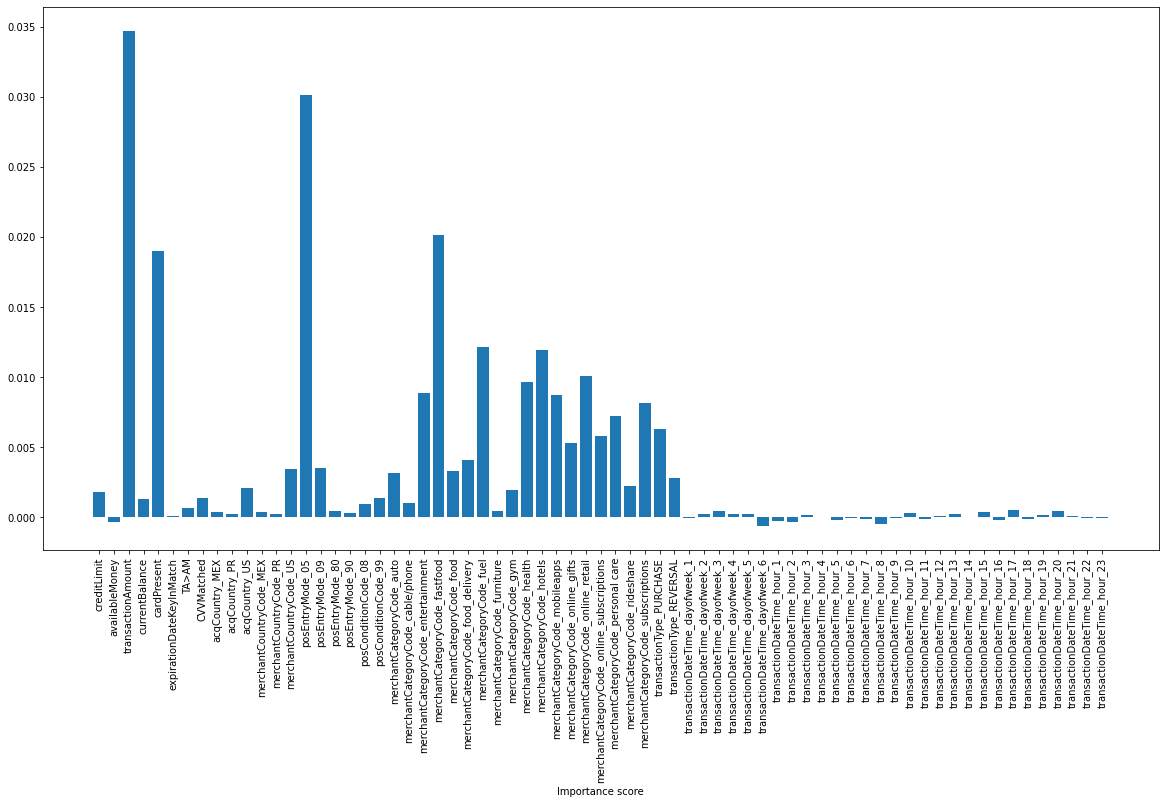

In [102]:
pi = permutation_importance(lr_model, X_train_sampled, y_train_sampled, random_state=0, scoring='accuracy')
coff = pi.importances_mean
plt.figure(figsize=(20,10))
plt.bar([i for i in range(0,len(coff))], coff)
plt.xlabel('Importance score')
plt.xticks(list(range(0,69)),dataset.columns, rotation=90)
plt.show()

# conclusion

## best model

The linear models Logisticregression and SVM performed well in detecting the Fraud transactions on test dataset. But they fail to detect the Not-Fraud transactions as good as tree models. <br><br>
On the other hand the Artificial Neural Network(ANN), predicted decently on test dataset. As neural networks overfit easily, I believe much more finetuning for right amount of neurons in each layer and number of layer will improve the performance.<br><br>
All the tree models DecisionTree, RandomForest, XGBoost performed well in detecting both the classes Fraud and Not-Fraud. All the models had decent precision and recall. <br><br>
The test dataset is also highly imbalanced and so, the precison for minority class is low. <br><br>

Finally, compared to all the models RandomForest is the best performing model both on train and test sets with overall accuracies of 80% and 70% respectively.

## important features

From the feature important scores from all the models and permutation feature importance, we can conclude that below are the top 5 important features <br><br>
transactionAmount<br>
posEntryMode<br>
merchantCategoryCode<br>
cardPresent<br>
currentBalance<br>

What you would do next with more time?<br>

•	I would like to explore the data further to see if any new feature can be created to increase the model’s performances.<br>
•	Also, I would like to try out more Under Sample and Over Sample techniques and assess the performances. As of now, I have tried only one technique for each sampling type.<br>
•	Oversampling the training data increased the total training time for each model. I would like to implement dimensionality reduction techniques like PCA to boost the training time.
